<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/Voip_carbon_footprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [265]:
from google.colab import drive
drive.mount('/content/drive')
import glob
from zipfile import ZipFile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [266]:
!pip install carbonfootprint==1.2.3

In [267]:
from carbonfootprint.carbon import Carbon
from carbonfootprint.fuelmix import Fuelmix

In [290]:
nRowsRead = 1000
df = pd.read_csv('/content/Historical half hour calls 2019.csv' ,delimiter=';', nrows = nRowsRead)

# df = pd.read_csv('/content/Historical half hour calls 2019.csv' ,delimiter=';')
df.dataframeName = 'Historical half hour calls.csv'
df.head(5)

,DateTime24,FullName,CallsOffered,CallsAnswered,CallsHandled,CallsQueued,AbandCalls,asa,AvgHandledCallsTalkTime,fte_AgentsActive,fte_AgentsLogonTotal,fte_AgentsNotReady,RouterCallsOffered,TotalQueued,RouterMaxCallsQueued,RouterCallsAbandQ,ServiceLevelCallsAband,ServiceLevelCallsOffered,ServiceLevelCalls,ServiceLevel,ShortCalls
0,2019-01-01 00:00,CCM.TB_2LTP_FTK,0,0,0,0,0,0:00:00,0,0,2,1,0,0,0,0,0,0,0,0.00,0
1,2019-01-01 00:30,CCM.TB_2LTP_FTK,3,2,1,3,2,0:00:58,773,1,2,1,4,3,3,2,0,4,1,0.25,0
2,2019-01-01 01:00,CCM.TB_2LTP_FTK,1,0,1,0,0,0:00:00,488,0,2,1,0,0,0,0,0,0,0,0.00,0
3,2019-01-01 01:30,CCM.TB_2LTP_FTK,2,2,2,1,0,0:06:04,601,1,1,0,2,1,1,0,0,2,1,0.50,0
4,2019-01-01 02:00,CCM.TB_2LTP_FTK,0,1,0,0,0,0:00:03,0,0,1,0,1,0,0,0,0,1,1,1.00,0


In [273]:
df.columns

Index(['DateTime24', 'FullName', 'CallsOffered', 'CallsAnswered',
       'CallsHandled', 'CallsQueued', 'AbandCalls', 'asa',
       'AvgHandledCallsTalkTime', 'fte_AgentsActive', 'fte_AgentsLogonTotal',
       'fte_AgentsNotReady', 'RouterCallsOffered', 'TotalQueued',
       'RouterMaxCallsQueued', 'RouterCallsAbandQ', 'ServiceLevelCallsAband',
       'ServiceLevelCallsOffered', 'ServiceLevelCalls', 'ServiceLevel',
       'ShortCalls'],
      dtype='object')

In [291]:
df['Timestamp'] = pd.to_datetime(df['DateTime24'].apply(str), format = '%Y-%m-%d %H:%M:%S')
df[["AnsweredCallTimeTalked"]]= df["AvgHandledCallsTalkTime"] * df["CallsAnswered"]
df[["Timestamp","AnsweredCallTimeTalked"]].head()

,Timestamp,AnsweredCallTimeTalked
0,2019-01-01 00:00:00,0
1,2019-01-01 00:30:00,1546
2,2019-01-01 01:00:00,0
3,2019-01-01 01:30:00,1202
4,2019-01-01 02:00:00,0


In [292]:
# df['Timestamp'].head()
# df= df[df['Timestamp'].dt.date == datetime.date(2019,1,1)]
df_hourly = df.resample('H',on='Timestamp').agg({ 
                                        'AnsweredCallTimeTalked':'sum',
                                        'DateTime24':'first'})
df_hourly = df_hourly.reset_index(drop=True)

Text(0, 0.5, 'AnsweredCallTimeTalked')

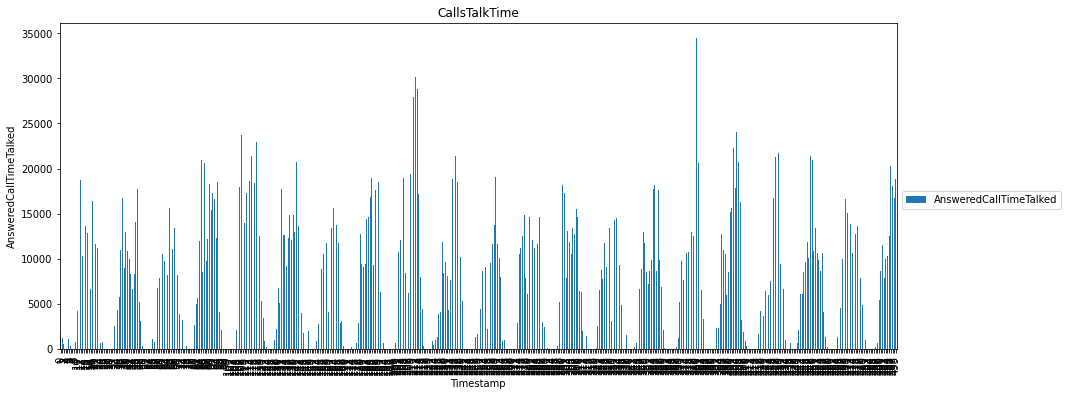

In [293]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
df_hourly.plot.bar( 
    # x = "DateTime24",
    y = ["AnsweredCallTimeTalked"],
    title = "CallsTalkTime" ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("AnsweredCallTimeTalked")

In [294]:
df_hourly["CallTime(hour)"] = df_hourly["AnsweredCallTimeTalked"]/60

# Dataset2

In [278]:
df = pd.read_csv('/content/plot-data.csv' ,delimiter=',')
df.dataframeName = 'calls.csv'
df =   df.rename(columns={"x": "Timestamp"," y" :"callsperminute" })
df['Timestamp'] = pd.to_datetime(df['Timestamp'].apply(str), format = '%Y-%m-%d %H:%M')
df['callsperminute'] = df['callsperminute']*1000
df.head(5)

,Timestamp,callsperminute
0,2019-01-01 00:02:35,556.586271
1,2019-01-01 00:16:42,742.115028
2,2019-01-01 00:24:25,1113.172542
3,2019-01-01 00:39:50,742.115028
4,2019-01-01 00:55:15,742.115028


Text(0, 0.5, 'callsperminute')

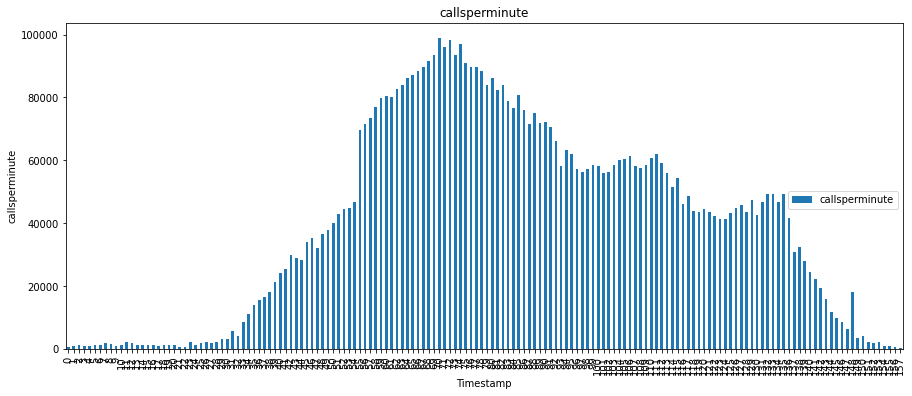

In [279]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
df.plot.bar( 
    y = ["callsperminute"],
    title = "callsperminute" ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("callsperminute")

In [280]:
df_hourly = df.resample('H',on='Timestamp').agg({ 
                                      'callsperminute':'sum'})
df_hourly =   df_hourly.rename(columns={"callsperminute": "CallTime(hour)"})
df_hourly = df_hourly.reset_index(drop=True)
df_hourly.head()

,CallTime(hour)
0,3896.103896
1,6122.448980
2,6679.035250
3,6493.506494
4,5751.391466


In [281]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 6)
# df_hourly.plot.bar( 
#     y = ["CallTime(hour)"],
#     title = "CallTime(hour)" ,
#     ax=ax) 
# ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
# ax.set_xlabel("Timestamp")
# ax.set_ylabel("CallTime(hour)")

# Energy consumption 

In [295]:
df_hourly["energyConsumption(kWh)"] = df_hourly["CallTime(hour)"]*0.4
df_hourly["power(W)"]= df_hourly["energyConsumption(kWh)"]/60

Text(0, 0.5, 'power(W)')

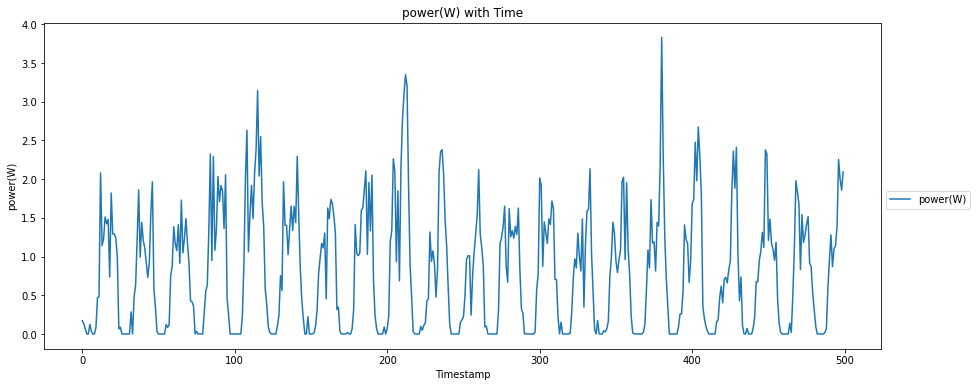

In [296]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
df_hourly.plot( 
    # x = "DateTime24",
    y = ["power(W)"],
    title = "power(W) with Time" ,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("power(W)")

# Carbon Emission in region

In [284]:
column_list = ("Wind",    "Solar",  "Hydro",  "Other",    "Petroleum",  "Natural gas", "Coal",     "Nuclear",  "Battery", "Imports")
column_list_carbon = [ "carbon_"+sub + "(kgeCO2)" for sub in column_list]

## ISONE

In [297]:
region ="isone"
furlpercent_obj = Fuelmix(region)
df_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(df_hourly)

carbonemissio_pbj = Carbon()
hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(df_hourly_fuelmix)

   AnsweredCallTimeTalked        DateTime24  ...  energyConsumption(kWh)  power(W)
0                    1546  2019-01-01 00:00  ...               10.306667  0.171778
1                    1202  2019-01-01 01:00  ...                8.013333  0.133556
2                     550  2019-01-01 02:00  ...                3.666667  0.061111
3                       0  2019-01-01 03:00  ...                0.000000  0.000000
4                       0  2019-01-01 04:00  ...                0.000000  0.000000

[5 rows x 5 columns]
utility_fuelmix filenames /usr/local/lib/python3.7/dist-packages/carbonfootprint/dataset/isone2020/*.csv
  Region Code  ... Imports Generation (%)
0          NE  ...                    0.0
1          NE  ...                    0.0
2          NE  ...                    0.0
3          NE  ...                    0.0
4          NE  ...                    0.0

[5 rows x 24 columns]


Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

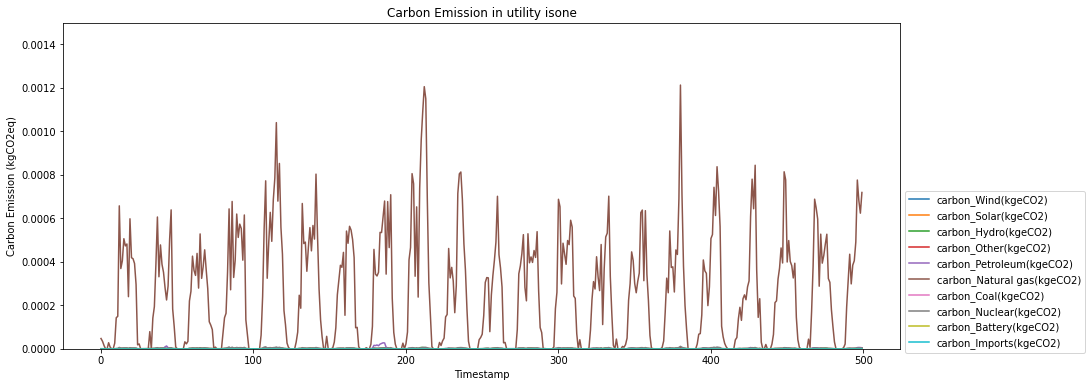

In [299]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
hourly_fuelmix_carbon.plot( 
    # x = "DateTime24",
    y = np.array(column_list_carbon),
    title = "Carbon Emission in utility "+ region ,
    ax=ax) 
plt.ylim([0,0.0015])
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")

## NorthWest

   AnsweredCallTimeTalked  ... carbon_total(kgeCO2)
0                    1546  ...             0.000048
1                    1202  ...             0.000035
2                     550  ...             0.000015
3                       0  ...             0.000000
4                       0  ...             0.000000

[5 rows x 27 columns]
utility_fuelmix filenames /usr/local/lib/python3.7/dist-packages/carbonfootprint/dataset/north_west2020/*.csv
  Region Code  ... Imports Generation (%)
0          NW  ...                    0.0
1          NW  ...                    0.0
2          NW  ...                    0.0
3          NW  ...                    0.0
4          NW  ...                    0.0

[5 rows x 24 columns]


Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

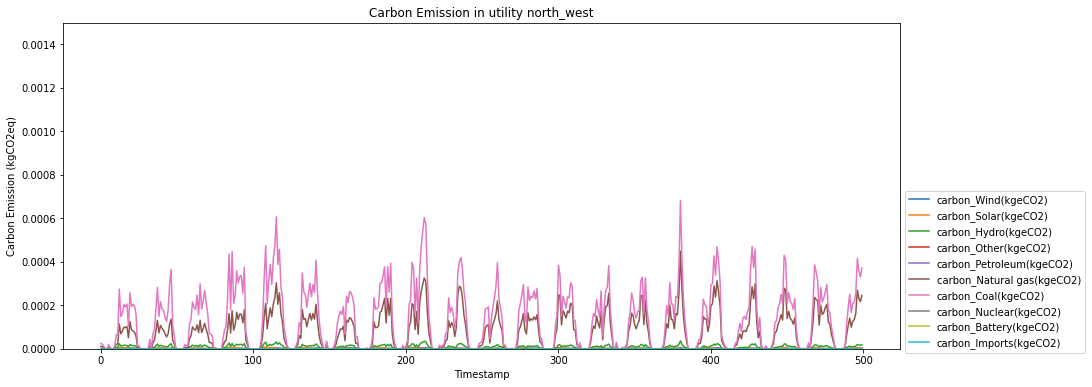

In [300]:
region ="north_west"
furlpercent_obj = Fuelmix(region)
df_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(df_hourly)

carbonemissio_pbj = Carbon()
hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(df_hourly_fuelmix)

fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
hourly_fuelmix_carbon.plot( 
    # x = "DateTime24",
    y = np.array(column_list_carbon),
    title = "Carbon Emission in utility "+ region ,
    ax=ax) 
# plt.ylim([0, 3])
plt.ylim([0,0.0015])
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")

## CAISO

   AnsweredCallTimeTalked  ... carbon_total(kgeCO2)
0                    1546  ...             0.000050
1                    1202  ...             0.000036
2                     550  ...             0.000016
3                       0  ...             0.000000
4                       0  ...             0.000000

[5 rows x 27 columns]
utility_fuelmix filenames /usr/local/lib/python3.7/dist-packages/carbonfootprint/dataset/caiso2020/*.csv
  Region Code  ... Imports Generation (%)
0         CAL  ...                    0.0
1         CAL  ...                    0.0
2         CAL  ...                    0.0
3         CAL  ...                    0.0
4         CAL  ...                    0.0

[5 rows x 24 columns]


Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

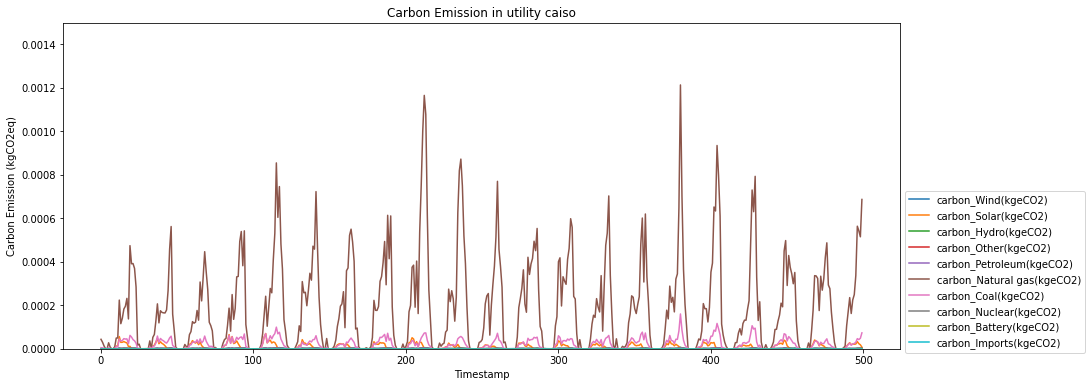

In [302]:
region ="caiso"
furlpercent_obj = Fuelmix(region)
df_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(df_hourly)

carbonemissio_pbj = Carbon()
hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(df_hourly_fuelmix)

fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
hourly_fuelmix_carbon.plot( 
    # x = "DateTime24",
    y = np.array(column_list_carbon),
    title = "Carbon Emission in utility "+ region ,
    ax=ax) 
# plt.ylim([0, 3])
plt.ylim([0,0.0015])
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")